# 🏦 Loan Approval Prediction: Logistic Regression & Model Optimization

This notebook explores a classification problem using a loan approval dataset. The goal is to build a model that predicts whether a loan application will be approved based on applicant information such as income, marital status, credit history, and other features.

We start with exploratory data analysis and preprocessing, then build a baseline logistic regression model using all available features. From there, we refine the model through feature importance analysis, threshold tuning, and performance evaluation using metrics like precision, recall, and confusion matrices.

Along the way, we also compare the logistic regression model against ensemble models like Random Forest, Gradient Boosting, XGBoost, and LGBM to check if they offer meaningful improvements.

The focus is not just on accuracy but also on model interpretability, reducing false approvals, and balancing performance across classes.


In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv
/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv


In [23]:
train =  pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv')

Check For NAN values

In [24]:
df = train.copy()
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [25]:
#check for duplicated values
df.duplicated().sum()

0

The target values `y` are currently of type object, which can cause issues with many machine learning models. We'll convert them to int to ensure compatibility. We'll also separate the target column from the feature set `X` to prepare for modeling.

In [26]:
X = df.drop('Loan_Status', axis= 1)
y = df['Loan_Status']
y = y.map({'N': 0, 'Y': 1})
y.dtypes

dtype('int64')

Creating a new feature column for `TotalIncome`—the combined income of the applicant and co-applicant—may improve model performance. This can help capture overall financial capacity more effectively than using the individual income columns separately.

In [27]:
X['TotalIncome'] = X['ApplicantIncome'] + X['CoapplicantIncome'] 

# Baseline model
Here we create a pipeline. In the pipline we will use SimpleImputer to handle the NAN values in the numeric cols and catagory cols. For the numeric cols we will use strategy `mean` and for the catagorey cols we will use strategy `most_frequent`. We will then OneHotEncode the cat cols. 
We will do all this in the pipline to make it easier to reproduce for the testing

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

numeric_preprocessor = Pipeline(
    steps =[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy='mean')),
        ("scaler", StandardScaler())
    ]
)

categorical_preprocessor = Pipeline(
    steps = [
        ("imputation_frequent", SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('cat', categorical_preprocessor,['Dependents','Gender','Married', 'Self_Employed','Property_Area']),
        ('num', numeric_preprocessor,['TotalIncome','Loan_Amount_Term','Credit_History'])
    ]
)


In this section, we test several models and print their cross-validation scores to compare performance and identify the best baseline classifier.

In [29]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=0),
    'GradientBoost': GradientBoostingClassifier(random_state=0),
    'XGBoost': XGBClassifier(n_estimators=400, learning_rate=0.05,
                             max_depth=4, random_state=0, use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LGBMClassifier': LGBMClassifier(n_estimators=400, learning_rate=0.05,
                                     max_depth=4, random_state=0, verbose=-1)
}

fitted_pipes = {}
for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    score = cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()
    print(f'{name}: {score:.4f}')
    fitted_pipes[name] = pipe

RandomForest: 0.7394
GradientBoost: 0.7867
XGBoost: 0.7655
LogisticRegression: 0.8127
LGBMClassifier: 0.7801


Logistic Regression had the highest cross-validation score of 0.8127, so we’ll focus on this model moving forward. Next, we'll compare its performance on the training and test sets to check for signs of overfitting or underfitting.

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 0, stratify=y)
from sklearn.metrics import accuracy_score, classification_report
best_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

best_pipe.fit(X_train, y_train)
#create a funciton to compare train vs test from train_test_split
def train_to_test (fitted):

    predictions1 = fitted.predict(X_train)
    predictions2 = fitted.predict(X_test)

    print('*******train********')
    print(classification_report(y_train, predictions1))
    print('*******test********')
    print(classification_report(y_test, predictions2))
    print("train Accuracy:", accuracy_score(y_train, predictions1))
    print("Test Accuracy:", accuracy_score(y_test, predictions2))
train_to_test(best_pipe)

*******train********
              precision    recall  f1-score   support

           0       0.92      0.44      0.59       154
           1       0.79      0.98      0.88       337

    accuracy                           0.81       491
   macro avg       0.85      0.71      0.73       491
weighted avg       0.83      0.81      0.79       491

*******test********
              precision    recall  f1-score   support

           0       0.89      0.42      0.57        38
           1       0.79      0.98      0.87        85

    accuracy                           0.80       123
   macro avg       0.84      0.70      0.72       123
weighted avg       0.82      0.80      0.78       123

train Accuracy: 0.8105906313645621
Test Accuracy: 0.8048780487804879


The difference between both CV scores is very minimal, suggesting no overfitting. However the recall difference is quiet large, suggest false negatives are high (predicting “Approved” when it should be “Not Approved”). We can address this with `class_weight='balanced'` in the classifier  LogisticRegression to improve Class 0 recall.

In [31]:
new_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, class_weight='balanced'))
new_pipe.fit(X_train, y_train)

train_to_test(new_pipe)

*******train********
              precision    recall  f1-score   support

           0       0.63      0.56      0.60       154
           1       0.81      0.85      0.83       337

    accuracy                           0.76       491
   macro avg       0.72      0.71      0.71       491
weighted avg       0.75      0.76      0.76       491

*******test********
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        38
           1       0.83      0.87      0.85        85

    accuracy                           0.79       123
   macro avg       0.75      0.74      0.74       123
weighted avg       0.78      0.79      0.79       123

train Accuracy: 0.7596741344195519
Test Accuracy: 0.7886178861788617


### Adjusting for Class Imbalance with class_weight='balanced'
By using `class_weight='balanced'` in our Logistic Regression model, we aimed to improve the model’s ability to correctly identify the minority class (loan applications that should not be approved).

While overall accuracy dropped slightly (from ~80% to ~79%), the recall for Class 0 (Not Approved) improved significantly on both the training and test sets. This is a meaningful trade-off: in a loan approval setting, false negatives (predicting Approved when the loan should actually be Declined) carry more risk than false positives. A false negative can lead to approving a loan for someone who doesn't meet the criteria, which may result in financial loss for the lender.

Improving recall for the “Not Approved” class makes the model more cautious, which is generally preferred in high-stakes decisions like loan approvals. Accuracy alone doesn’t tell the full story—this improvement shows the importance of balancing performance across classes.

## Hyperparameter Tuning with GridSearchCV
To further improve our Logistic Regression model, we used `GridSearchCV` to perform an exhaustive search over a range of hyperparameters. This process helps identify the best combination of settings that maximize model performance based on cross-validation.

We tuned the following hyperparameters:

* `C`: Inverse of regularization strength (tested values: 0.01, 0.1, 1, 10, 100)

* `penalty`: Regularization type (l2 was used, which is standard for Logistic Regression)

* `solver`: Algorithm to use in the optimization problem (lbfgs and liblinear)

* `class_weight`: Adjusts for class imbalance (balanced was included to improve recall on the minority class)

Using 5-fold cross-validation, `GridSearchCV` evaluated each combination and returned the one with the highest average accuracy.

This step helps ensure we’re not just fitting a good model, but one that’s optimized for generalization to new, unseen data

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logisticregression__penalty': ['l2'],             # Usually 'l2' for scikit-learn solver
    'logisticregression__solver': ['lbfgs', 'liblinear'],
    'logisticregression__class_weight': ['balanced']
    
}

grid = GridSearchCV(best_pipe, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print(f"Best Params: {grid.best_params_}")
print(f"Best CV Score: {grid.best_score_:.4f}")
#print(classification_report(y_test, predictions2))

Best Params: {'logisticregression__C': 0.01, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Best CV Score: 0.8005


Using the results from `GridSearchCV`, we now create a new Logistic Regression model with the best-performing hyperparameters. This step allows us to train and evaluate a model that is more fine-tuned to the data, which may improve overall performance and generalization on unseen data.

In [33]:
best_model = make_pipeline(preprocessor,LogisticRegression(C=.01, class_weight = 'balanced', penalty='l2', solver='lbfgs', max_iter=1000))

In [34]:
best_model.fit(X_train, y_train)
train_to_test(best_model)

*******train********
              precision    recall  f1-score   support

           0       0.84      0.45      0.58       154
           1       0.79      0.96      0.87       337

    accuracy                           0.80       491
   macro avg       0.82      0.70      0.73       491
weighted avg       0.81      0.80      0.78       491

*******test********
              precision    recall  f1-score   support

           0       0.89      0.42      0.57        38
           1       0.79      0.98      0.87        85

    accuracy                           0.80       123
   macro avg       0.84      0.70      0.72       123
weighted avg       0.82      0.80      0.78       123

train Accuracy: 0.8004073319755601
Test Accuracy: 0.8048780487804879


### Final Model Performance

After tuning hyperparameters and rebuilding the Logistic Regression model, the results show that performance remains consistent with previous versions.

- **Train Accuracy:** 80.04%
- **Test Accuracy:** 80.49%

The model continues to perform well on both training and test sets, with minimal signs of overfitting. However, while accuracy is strong, the recall for class `0` (Loan Not Approved) remains low. This means the model still tends to predict more loan approvals than it should. In real-world loan approval scenarios, failing to identify high-risk applicants could carry financial consequences. Further improvements may require additional feature engineering, data balancing, or exploring alternative models.


### Create a Function to Plot a Confusion Matrix

To better visualize model performance, we'll define a reusable function to plot the confusion matrix. This function takes in the model, feature set, and true labels, and displays the confusion matrix with labeled axes and color shading for better clarity.


In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['not approved', 'approved']); ax.yaxis.set_ticklabels(['not approved', 'approved'])

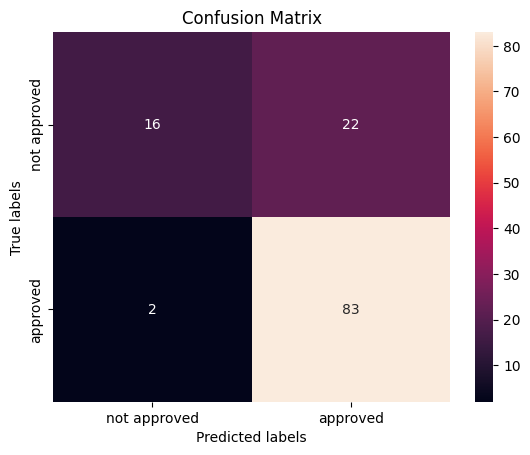

In [36]:
yhat = best_model.predict(X_test)
plot_confusion_matrix(y_test,yhat)

Get predicted probabilities

### Plot Precision-Recall vs Threshold

To understand how different probability thresholds affect precision and recall, we plot both metrics against various threshold values. This helps us choose an optimal threshold for classification decisions, especially in imbalanced datasets where accuracy alone may be misleading.


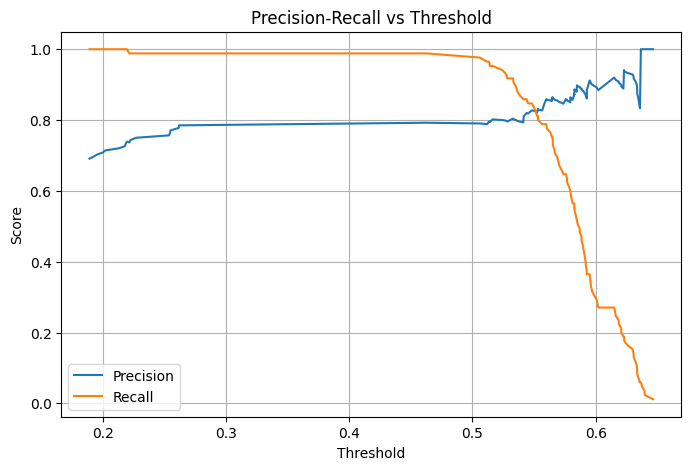

In [37]:
from sklearn.metrics import precision_recall_curve
probs = best_model.predict_proba(X_test)[:, 1]
precision, recall, pr_thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(pr_thresholds, precision[:-1], label='Precision')
plt.plot(pr_thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

### Evaluate Model at a Custom Threshold

Instead of using the default 0.5 threshold, we manually set a custom threshold of 0.52 to convert predicted probabilities into class labels. This allows us to fine-tune the trade-off between precision and recall based on the problem context. After applying the threshold, we evaluate the model using a classification report and confusion matrix.


              precision    recall  f1-score   support

           0       0.78      0.47      0.59        38
           1       0.80      0.94      0.86        85

    accuracy                           0.80       123
   macro avg       0.79      0.71      0.73       123
weighted avg       0.79      0.80      0.78       123



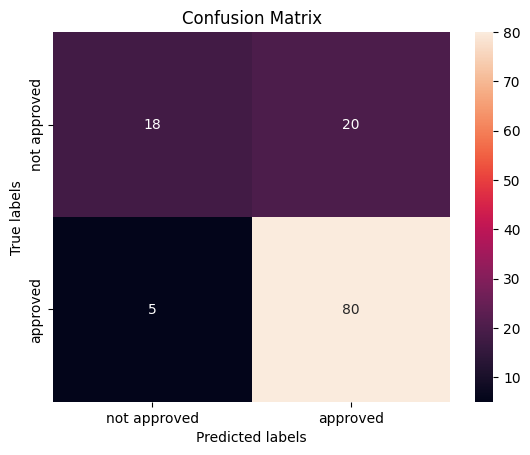

In [38]:
y_pred_custom = (probs > .52).astype(int)
print(classification_report(y_test, y_pred_custom))
plot_confusion_matrix(y_test, y_pred_custom)

### Evaluation Results at Custom Threshold (0.52)

Adjusting the classification threshold to 0.52 led to a more balanced performance between classes. Class 0 (Not Approved) recall improved compared to the default threshold, which helps reduce false positives (i.e., predicting "Approved" when it shouldn't be). This is especially important in loan approval settings where misclassifying unqualified applicants can lead to financial risk.

| Metric         | Class 0 | Class 1 |
|----------------|---------|---------|
| Precision      | 0.78    | 0.80    |
| Recall         | 0.47    | 0.94    |
| F1-score       | 0.59    | 0.86    |
| **Accuracy**   | **0.80** overall

The custom threshold offers a practical improvement in recall for the minority class, which could better support business goals depending on the use case.


# Feature Importance Analysis

### Top 10 Most Influential Features in Logistic Regression

To better understand which features had the greatest impact on the model's predictions, we extracted the coefficients from the trained Logistic Regression model. Using the pipeline's preprocessor, we matched each coefficient to its corresponding feature.

Below are the top 10 features sorted by absolute coefficient magnitude, representing the most influential inputs in predicting loan approval

In [39]:
# Get the best model Logistic Regression model
log_reg = best_model.named_steps['logisticregression']

# Get feature names from the preprocessor
feature_names = best_model.named_steps['columntransformer'].get_feature_names_out()

# Pair each feature name with its coefficient
coefficients = pd.Series(log_reg.coef_[0], index=feature_names)

# Sort by importance
coefficients.abs().sort_values(ascending=False).head(10)

num__Credit_History             0.563174
cat__Property_Area_Semiurban    0.115544
cat__Property_Area_Rural        0.081130
cat__Married_No                 0.070935
cat__Married_Yes                0.070935
num__TotalIncome                0.042041
cat__Dependents_1               0.037495
cat__Dependents_2               0.035860
cat__Property_Area_Urban        0.034414
cat__Gender_Female              0.019868
dtype: float64

🔍 Feature Importance Summary
To better understand what influenced our model's predictions, we extracted the coefficients from the final Logistic Regression model. Using the names from our ColumnTransformer, we matched each feature to its corresponding weight.

The results showed that the most important feature by far was `Credit_History`, followed by indicators for property location (`Property_Area_Semiurban, Property_Area_Rural`) and dependent/marital status (`Dependents_1`, `Married_Yes`, etc.).

These coefficients reflect the magnitude of each feature’s impact on the model’s decision — not whether it increased or decreased the chance of loan approval, but how strongly it influenced the prediction. This helped guide our feature reduction and model refinement in the next steps.

### Feature Reduction

To simplify the model and potentially improve generalization, we will perform feature reduction by selecting the top 10 most influential features based on the absolute values of the Logistic Regression coefficients. 

Using these features, we’ll rebuild the pipeline and retrain the model to evaluate if performance can be maintained or improved with fewer inputs.

In [40]:
important_numeric = Pipeline(
    steps =[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy='mean')),
        ("scaler", StandardScaler())
    ]
)

important_cat = Pipeline(
    steps = [
        ("imputation_frequent", SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor_important = ColumnTransformer(
    [
        ('cat', important_cat,['Dependents','Married','Property_Area']),
        ('num', important_numeric,['TotalIncome','Credit_History'])
    ]
)

# New pipeline
reduced_pipe = Pipeline([
    ('preprocessor', preprocessor_important),
    ('logisticregression', LogisticRegression(C=.01, class_weight = 'balanced', penalty='l2', solver='lbfgs', max_iter=1000))
])

In [41]:
reduced_pipe.fit(X_train, y_train)
train_to_test(reduced_pipe)

*******train********
              precision    recall  f1-score   support

           0       0.84      0.45      0.58       154
           1       0.79      0.96      0.87       337

    accuracy                           0.80       491
   macro avg       0.82      0.70      0.73       491
weighted avg       0.81      0.80      0.78       491

*******test********
              precision    recall  f1-score   support

           0       0.89      0.42      0.57        38
           1       0.79      0.98      0.87        85

    accuracy                           0.80       123
   macro avg       0.84      0.70      0.72       123
weighted avg       0.82      0.80      0.78       123

train Accuracy: 0.8004073319755601
Test Accuracy: 0.8048780487804879


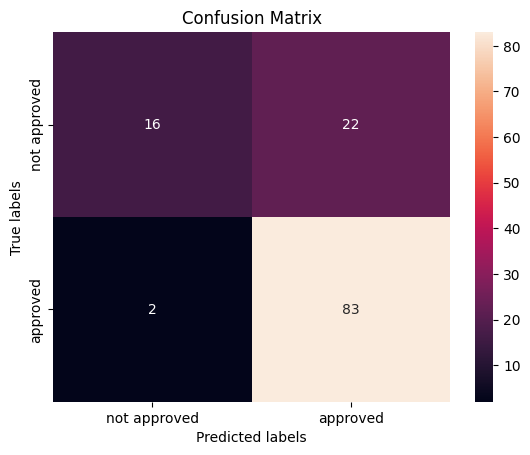

In [42]:
yhat = reduced_pipe.predict(X_test)
plot_confusion_matrix(y_test,yhat)

### Insights

After reducing the feature set to only the most impactful variables, the model's performance remained nearly identical to the full-feature version. The confusion matrix confirms that the balance between false positives and false negatives was maintained. 

This suggests that the core predictive power lies in a small number of features, which makes the model:
- Easier to interpret
- Faster to train and run
- Less prone to overfitting

Overall, simplifying the model led to a more efficient pipeline without sacrificing accuracy.


### Comparing Full vs Reduced Model Performance

To evaluate whether reducing the number of features impacts model performance, we compare the classification metrics—accuracy, precision, recall, and F1-score—of the full model and the reduced model.

This comparison helps us determine if a simpler model (fewer features) performs just as well as the more complex version. If the reduced model performs similarly, we can justify using it due to its increased interpretability, faster inference time, and potentially lower risk of overfitting.

We define a helper function `get_metrics()` to calculate the key metrics and display them side-by-side for easy comparison.

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

results = pd.DataFrame({
    "Full Model": get_metrics(y_test, best_model.predict(X_test)),
    "Reduced Model": get_metrics(y_test, reduced_pipe.predict(X_test))
})

results.T  # Transpose for readability


,Accuracy,Precision,Recall,F1
Full Model,0.804878,0.790476,0.976471,0.873684
Reduced Model,0.804878,0.790476,0.976471,0.873684


### 🔍 Model Comparison Summary

After selecting the top features based on logistic regression coefficients, we trained a reduced model using only those important features. We then compared its performance to the original full-feature model.

**Key Result:**  
The reduced model achieved the **same performance** as the original model on both the training and test sets:

- **Train Accuracy:** 80.0%
- **Test Accuracy:** 80.5%
- **Precision, Recall, F1:** Nearly identical across classes

**What this tells us:**
- Most of the model’s predictive power came from a small subset of features.
- Removing less informative features led to a simpler, more interpretable model without sacrificing performance.
- This reinforces that a leaner model can still be highly effective — a useful insight for production use or stakeholder explanation.

Next steps could include using this leaner model as the final version, or trying regularization tuning or ensemble methods for incremental gains.
